# Paper Citation Prediction
*by Kazybek Askarbek([github](https://github.com/qazybi))*
\
\
*This notebook provides extensive data analysis, cleaning of the datasets, feature generation and visual analysis*
\
\
**Contents:**
- [Problem definition](#scrollTo=37h0gWaxWx7Y&line=3&uniqifier=1)
- [Data retrieval](#scrollTo=477aa5d1-4046-4a55-bd9e-bf4736cb39c0&line=4&uniqifier=1)
- [Data preprocessing](#scrollTo=a3cdc23b-b8f6-4eda-81f2-601e81db87be&line=5&uniqifier=1)
- Feature generation
- Visual analysis 
---

**Additional Modules**
- Dataretr - module for downloading data and making dataframes out of it.
- Dataprep - module for cleaning the data and generating features.
- Info - module with configurations
- Features - module to generate new features


## Problem definition

We believe many researchers want to have many citations and get high h-index. However, when there are numerous papers published each year it becomes difficult to obtain more citations. \

In order to help researchers improve scientific impact of their work we present you the automatic tool. The tool analyzes the title, abstract, publication journal, year, and other meta information disregarding the content. \

Then, system predicts the number of citations the paper will have after five years. Based on the result researcher will decide whether to improve the title, change publication journal or make abstract shorter.

Five year time frame was used as it was in the [paper - "Can Scientific Impact Be Predicted?"](https://arxiv.org/pdf/1606.05905.pdf). 

**Target variable** - Number of citations after five year since publication

## Data Retrieval

*In this section we retrieve all the data from the server.*
\
\
`Dataretr` module contains functions to download and convert them to the pandas dataframe. We will heavily use functions from the module.

As the analysis goes under limited computational and memory resources we will be considering only 30 files from the full dataset. 

Even though, 30 zip files contain around **1M** papers metadata.



In case data already in the file system the `Dataretr` module will not download files again.

Instead will create DataFrame from existing files.

In [5]:
!git clone https://github.com/QazyBi/paper_citation_prediction.git

Cloning into 'paper_citation_prediction'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 42 (delta 13), reused 31 (delta 7), pack-reused 0
Unpacking objects: 100% (42/42), done.


In [5]:
!pip install scholarmetrics
!pip install catboost

In [6]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
%autoreload
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

# module with links and directory names
from info import *
# module for downloading and reading corpus
import dataretr
# module for preprocessing the data
import dataprep

In [8]:
# make request to get filenames
response = requests.get(manifest_link)
# for now we work with only 30 files
filenames = response.text.split('\n')[:30]

corpus: pd.DataFrame = dataretr.download_make_df(filenames, corpus_link, out_dir)

building dataframe: 100%|██████████| 30/30 [02:22<00:00,  4.76s/it]


## Data Preprocessing

*In this section we clean/transform features and remove redundant columns for our further use*
\
\
Here we will witness that the data is quite dirty and needs cleaning. 

By dirty, we mean that the columns contain jsons, lists and inconsistent notations.

We will tackle each issue. So let's get started!


We will visually observe the data. Our great tool is a `head` function. 

Mostly our data contains some string, list and few number columns.

Also, there are many empty cells!

Some papers were written not in English

In [9]:
corpus.head()

,title,paperAbstract,authors,inCitations,outCitations,year,s2Url,sources,pdfUrls,venue,journalName,journalVolume,journalPages,doi,doiUrl,pmid,fieldsOfStudy,magId,s2PdfUrl,entities
id,,,,,,,,,,,,,,,,,,,,
33b237709dbd53953a750355115b57ccb6690da1,USING PHOTO IMAGES TO DETERMINE THE GEOMETRIC ...,,"[{'name': 'E Popov', 'ids': ['144112922']}, {...",[],[],2019.0,https://semanticscholar.org/paper/33b237709dbd...,[],[],,,19,45-54,10.14529/build190307,https://doi.org/10.14529/build190307,,[Computer Science],3000193832,,[]
062e9c7579adc73129e1198671d05905f07d4ab5,Clinical or Industrial Pharmacy? Case Studies ...,Automated medication dispensing systems for ho...,"[{'name': 'J Novek', 'ids': ['47586327']}]","[799bde07f3e9dc7f39d30ae9e1ac29cda9cd5a5c, 59a...","[a402dac75befed8c389fe00a3b6eed7ee8da87e1, 7d9...",1998.0,https://semanticscholar.org/paper/062e9c7579ad...,[Medline],[],International journal of health services : pla...,International Journal of Health Services,28,445 - 465,10.2190/W2BT-FGXQ-QL0G-YNL9,https://doi.org/10.2190/W2BT-FGXQ-QL0G-YNL9,9711475,[Medicine],1988383910,,[]
771723e7e2d9ed97d09442086553b726f0dd6657,Noncoronary and coronary atherothrombotic plaq...,"In the future, the use of imaging methods to q...","[{'name': 'Zahi A Fayad', 'ids': ['1886137']}]","[ba2cbbac306fa374c7c07da398e31a52c5680a58, 494...","[3109764f646de80e096609f86b5e4bf19320c81c, aea...",2002.0,https://semanticscholar.org/paper/771723e7e2d9...,[Medline],[],Neuroimaging clinics of North America,Neuroimaging clinics of North America,12 3,\n 461-71\n,10.1016/S1052-5149(02)00023-0,https://doi.org/10.1016/S1052-5149%2802%2900023-0,12486833,[Medicine],1983175018,,[]
263f70167ba7def67a2843ffc30c80a0b9b3f617,국어 명사구 접속의 연구,,"[{'name': '최재희', 'ids': ['115087709']}]",[],[],1985.0,https://semanticscholar.org/paper/263f70167ba7...,[],[],,,,,,,,[],2291560164,,[]
9ea1148fa657103879ef7ed9a5b716be48ee13a4,Who'll Take My Place : When I'm Gone,,"[{'name': 'Billy Fazioli', 'ids': ['146257415...",[],[],2018.0,https://semanticscholar.org/paper/9ea1148fa657...,[],[https://digitalcommons.library.umaine.edu/cgi...,,,,,,,,[Art],1489188979,,[]


The column names are sound. But for clarity we can describe shortly each. 

Columns:
- `id` - id of the paper in the Semantic Scholar database
- `title` - title of the paper
- `paperAbstract` - abstract of the paper
- `authors` - json containing names and ids of authors
- `inCitations` - papers ids which have cited current paper
- `outCitations` - papers ids which were cited by current paper
- `year` - year of publication
- `s2Url` - url to get the paper information
- `sources` - bibliographic source of the paper
- `pdfUrls` - link to the pdf
- `venue` - publishing platform
- `journalName` - name of the journal where paper published
- `journalVolume` - volume of the journal
- `journalPages` - at which pages the paper situated
- `doi` - digital object identifier
- `doiUrl` - link to the persistent location in the Internet
- `pmid` - id in the PubMed database
- `fieldsOfStudy` - fields to which paper relates
- `magId` - another identifier
- `s2PdfUrl` - link to the pdf in Semantic Scholar database
- `entities` - blank 
---

Following cell shows that only one column(year) is of the float type. 

We will convert or transform most of the columns to the numerical type since machine learning models work best with these types. 

> In the model selection section we will refer to one special model - **Catboost**, which can work with categorical(object) columns. 

In [10]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
Index: 954657 entries, 33b237709dbd53953a750355115b57ccb6690da1 to e3d5bbcd80b5b5927799164a8538d62966492fe5
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   title          954657 non-null  object 
 1   paperAbstract  954657 non-null  object 
 2   authors        954657 non-null  object 
 3   inCitations    954657 non-null  object 
 4   outCitations   954657 non-null  object 
 5   year           950001 non-null  float64
 6   s2Url          954657 non-null  object 
 7   sources        954657 non-null  object 
 8   pdfUrls        954657 non-null  object 
 9   venue          954657 non-null  object 
 10  journalName    954657 non-null  object 
 11  journalVolume  954657 non-null  object 
 12  journalPages   954657 non-null  object 
 13  doi            954657 non-null  object 
 14  doiUrl         954657 non-null  object 
 15  pmid           954657 non-null  object 
 16  fields

Let's get some simple statistical information about column `year`. 

Generally, mean of the papers around 2001.

However, there are very old papers published in 1601 and new papers published in 2021.

In [11]:
corpus.describe()

,year
count,950001.000000
mean,2001.785349
std,19.760317
min,1601.000000
25%,1996.000000
50%,2008.000000
75%,2014.000000
max,2021.000000


### Converting to np.nan

For the first glance there were many empty cells.

However, following function shows that the only column containing empty values is the `year` column.

Surely, this is because columns represent null values as **empty strings/lists** rather than `np.nan`

In [12]:
corpus.isna().sum()

title               0
paperAbstract       0
authors             0
inCitations         0
outCitations        0
year             4656
s2Url               0
sources             0
pdfUrls             0
venue               0
journalName         0
journalVolume       0
journalPages        0
doi                 0
doiUrl              0
pmid                0
fieldsOfStudy       0
magId               0
s2PdfUrl            0
entities            0
dtype: int64

We have manually selected columns which store in their cells the string and which store lists separately.

We will convert for our ease the empty strings to `np.nan`'s and will keep empty lists as they are.

> But to show that there are many rows with empty lists will make full transformations on the copy of the `corpus` dataframe

In [13]:
cols_with_strings = ['title', 'paperAbstract', 'venue', 
                     'journalName', 'journalVolume', 
                     'journalPages', 'doi', 'doiUrl', 
                     'pmid', 'magId', 's2PdfUrl', 's2Url']

cols_with_lists = ['sources', 'pdfUrls', 'outCitations',
                   'inCitations', 'authors', 'fieldsOfStudy', 'entities']

In [14]:
corpus_copy = corpus.copy()

for col in cols_with_strings:
    corpus_copy[col] = corpus_copy[col].apply(lambda x: np.nan if x == '' else x)
    
    # we will apply this transformation to the original corpus too
    corpus[col] = corpus[col].apply(lambda x: np.nan if x == '' else x)

for col in cols_with_lists:
    corpus_copy[col] = corpus_copy[col].apply(lambda x: np.nan if len(x) == 0 else x)

Now it is clear that there are many empty cell as we thought during our first acquaintance.

In [15]:
corpus_copy.isna().sum()

title                 1
paperAbstract    406416
authors           11697
inCitations      550998
outCitations     598795
year               4656
s2Url                 0
sources          769189
pdfUrls          778431
venue            737522
journalName      491361
journalVolume    456400
journalPages     404089
doi              464822
doiUrl           464822
pmid             794082
fieldsOfStudy    149760
magId             59404
s2PdfUrl         954657
entities         954657
dtype: int64

### Dropping columns with most np.nan

Even though we found out that there are many columns with empty cells,\
 let us show which columns have the most number of null values.


In [16]:
# percentage of null values in columns top 10
isna_series = corpus_copy.isna().sum() / len(corpus_copy) * 100
(isna_series).sort_values(ascending=False).iloc[:10] 

entities        100.000000
s2PdfUrl        100.000000
pmid             83.179823
pdfUrls          81.540386
sources          80.572289
venue            77.255182
outCitations     62.723575
inCitations      57.716855
journalName      51.469900
doi              48.689948
dtype: float64

In [17]:
# We can drop some of the columns as they mostly consist of np.nan 
corpus.drop(columns=['s2PdfUrl', 'entities', 'pmid', 'pdfUrls'], inplace=True)

### Drop rows with np.nan in year column

Drop rows where year column has np.nan since our predictions will be based on the year

In [18]:
corpus.dropna(subset=['year'], inplace=True)

### Clean author column

Authors columns contains valuable information, but first needs some cleaning.

A lot better to store just ids of paper authors than jsons. Thus we will keep only ids. 

However, some authors seem to have no id. We need to generate them new id.


In [19]:
corpus.authors

id
33b237709dbd53953a750355115b57ccb6690da1    [{'name': 'E  Popov', 'ids': ['144112922']}, {...
062e9c7579adc73129e1198671d05905f07d4ab5          [{'name': 'J  Novek', 'ids': ['47586327']}]
771723e7e2d9ed97d09442086553b726f0dd6657       [{'name': 'Zahi A Fayad', 'ids': ['1886137']}]
263f70167ba7def67a2843ffc30c80a0b9b3f617              [{'name': '최재희', 'ids': ['115087709']}]
9ea1148fa657103879ef7ed9a5b716be48ee13a4    [{'name': 'Billy  Fazioli', 'ids': ['146257415...
                                                                  ...                        
4c61aa8e7e85a88491e531b1983e3e85a6c82894         [{'name': 'V  Bhalla', 'ids': ['50789404']}]
0fae8e72274e9bc72dc31dc9b4f86aa617593706    [{'name': 'Lyudmyla O. Shyyko', 'ids': ['35805...
23a26492083561549b6eec014db0b539be62b3be    [{'name': 'Yulia  Solovieva', 'ids': ['7398685...
e2e97b3e97dd33d49a76c2ce757efbdff4a526ba    [{'name': 'M. A. Grado-Caffaro', 'ids': ['1405...
e3d5bbcd80b5b5927799164a8538d62966492fe5    [{'name': 'G 

Since there are some authors who do not have an id, \
we can get maximal id among authors and \
then generate new ids for those who do not have one
by just iterating that maximal id

In [20]:
%%time
author_prep = dataprep.AuthorPrep()

author_prep.get_max_id(corpus)

950001it [00:10, 91155.90it/s]

CPU times: user 9.6 s, sys: 768 ms, total: 10.4 s
Wall time: 10.4 s


Now we will generate new ids for those authors who do not have one.

In [21]:
%%time
author_prep.generate_ids()

CPU times: user 19.5 ms, sys: 976 µs, total: 20.5 ms
Wall time: 21.6 ms


Convert json in the authors column to the list of author ids

In [22]:
%%time
# apply function for each row in the dataframe
corpus.authors = corpus.authors.apply(author_prep.get_author_ids)

CPU times: user 2.51 s, sys: 76.8 ms, total: 2.59 s
Wall time: 2.6 s


Now, it is more cleaner and easier to work with

In [23]:
corpus.authors.head()

id
33b237709dbd53953a750355115b57ccb6690da1    [144112922, 108722565]
062e9c7579adc73129e1198671d05905f07d4ab5                [47586327]
771723e7e2d9ed97d09442086553b726f0dd6657                 [1886137]
263f70167ba7def67a2843ffc30c80a0b9b3f617               [115087709]
9ea1148fa657103879ef7ed9a5b716be48ee13a4    [146257415, 147923943]
Name: authors, dtype: object

### Clean journalPages column

Seems that journalPages column contains different formats for different papers, some have null values. \

To not spend a lot of time on this column and aviod noise in the data from improper parsing 

it was decided to skip this column!

In [24]:
corpus.journalPages

id
33b237709dbd53953a750355115b57ccb6690da1                           45-54
062e9c7579adc73129e1198671d05905f07d4ab5                       445 - 465
771723e7e2d9ed97d09442086553b726f0dd6657    \n          461-71\n        
263f70167ba7def67a2843ffc30c80a0b9b3f617                             NaN
9ea1148fa657103879ef7ed9a5b716be48ee13a4                             NaN
                                                        ...             
4c61aa8e7e85a88491e531b1983e3e85a6c82894     \n          453-8\n        
0fae8e72274e9bc72dc31dc9b4f86aa617593706                             NaN
23a26492083561549b6eec014db0b539be62b3be                             NaN
e2e97b3e97dd33d49a76c2ce757efbdff4a526ba                         543-544
e3d5bbcd80b5b5927799164a8538d62966492fe5    \n          99-107\n        
Name: journalPages, Length: 950001, dtype: object

### Clean journalVolume column

The same situation as with journalPages here.

In [25]:
corpus.journalVolume

id
33b237709dbd53953a750355115b57ccb6690da1      19
062e9c7579adc73129e1198671d05905f07d4ab5      28
771723e7e2d9ed97d09442086553b726f0dd6657    12 3
263f70167ba7def67a2843ffc30c80a0b9b3f617     NaN
9ea1148fa657103879ef7ed9a5b716be48ee13a4     NaN
                                            ... 
4c61aa8e7e85a88491e531b1983e3e85a6c82894    22 5
0fae8e72274e9bc72dc31dc9b4f86aa617593706      61
23a26492083561549b6eec014db0b539be62b3be     NaN
e2e97b3e97dd33d49a76c2ce757efbdff4a526ba     110
e3d5bbcd80b5b5927799164a8538d62966492fe5     8 1
Name: journalVolume, Length: 950001, dtype: object

### Drop columns with unique values

Following columns do not have correlations with target variable since each value in the columns are unique

In [26]:
corpus.drop(columns=['doi', 'doiUrl', 'magId', 's2Url'], inplace=True)

## Feature Generation

### Max h-index

In [27]:
cite_prep = dataprep.CitationsPrep()

In [28]:
%%time

# count number of citations for each paper and author
p_cite_count, a_cite_count = cite_prep.count(corpus)


CPU times: user 29min 13s, sys: 4.52 s, total: 29min 18s
Wall time: 29min 20s


In [29]:
%%time
max_h_values = cite_prep.calc_scholarmetrics(corpus, p_cite_count, a_cite_count)


CPU times: user 7min 10s, sys: 7.04 s, total: 7min 17s
Wall time: 7min 11s


In [30]:
max_h_values.most_common(10)

[('6e767d04937ed5dc9008734fcc6911663cf53682', 12),
 ('f200f06b704116acb25d7c9042dac870043d479c', 12),
 ('e728e07ff102bc4b489d23428c3b322e0bf9cda6', 12),
 ('f8b0073f3cbfc841d191c3c9db71e3588b387ff4', 12),
 ('cb3ee60c80fd0b65e9b6d25fd106a80af73dafcf', 12),
 ('f24650d2bb3f8e71d59982652124c52dcc72bcb5', 12),
 ('2d3f8a5d0406d90993147b78a128acd3937dde57', 12),
 ('ac9bfb4ef6a1b3db3143ccf5394edc1171725234', 12),
 ('766eaff36ee3a7be143bc9d1c8e43a89d053a88f', 12),
 ('4b327d6080b218f1659a163dd38f12e14671d1c4', 12)]

In [31]:
corpus['max_hindex'] = pd.DataFrame.from_dict(max_h_values, orient='index')

### Author number

In [32]:
corpus['n_authors'] = corpus.authors.apply(lambda x: len(x) if x is not np.nan else 0)

### Recency

In [33]:
# recency(current year - year of publication)
corpus.year = corpus.year.apply(lambda x: 2021 - x)
corpus.rename(columns={'year': 'recency'}, inplace=True)

### Lengths of title and abstract

In [34]:
get_len = lambda x: len(x) if x is not np.nan else 0

corpus['title_len'] = corpus.title.apply(get_len)
corpus['abstract_len'] = corpus.paperAbstract.apply(get_len)

### Citations number 

We will need to use citations information for building our model, 

this column will be our target variable, and we will do some operations with this column

Thus we will take it out to another dataframe

In [35]:
citation_info = pd.Series(p_cite_count)

In [36]:
citation_info, _ = citation_info.align(corpus, join='right', axis=0, fill_value=0)

In [37]:
corpus['citations_n'] = citation_info

### Venue's h-index

Not only authors have h-indices but venue's too.

Higher h-index of the platform of publication will result in higher citation counts too.

In [38]:
from scholarmetrics import hindex


groups = corpus.groupby('venue')
venue_hindex = groups['citations_n'].apply(lambda x: hindex(x.tolist()))

In [39]:
def get_venue_hindex(x):
    if x['venue'] is np.nan:
        return 0
    else:
        return venue_hindex[x['venue']]


corpus['venue_hindex'] = corpus.apply(lambda x: get_venue_hindex(x), axis=1)

### Average number of citations of papers published in this venue

In [40]:
venue_mean_cite = groups['citations_n'].apply(lambda x: x.mean())

def get_venue_mean_cite(paper: pd.Series):
    if paper['venue'] is np.nan:
        return 0
    else:
        return venue_mean_cite[paper['venue']]


corpus['venue_mean_cite'] = corpus.apply(lambda x: get_venue_mean_cite(x), axis=1)

### Average h-index of all authors of the paper

In [41]:
from typing import List

In [42]:
%%time


def get_hindices(authors: List) -> List:
    hindices = []
    for id in authors:
        if id in a_cite_count:
            citations = list(a_cite_count[id].values())
            h_index = hindex(citations)
        else:
            h_index = 0
        
        hindices.append(h_index)
    return hindices

def a_cite_avg(authors: List) -> float:
    hindices = get_hindices(authors)

    return sum(hindices) / len(hindices) if len(hindices) != 0 else 0

corpus['avg_hindices'] = corpus.authors.apply(lambda x: a_cite_avg(x))

CPU times: user 20.3 s, sys: 72.7 ms, total: 20.4 s
Wall time: 20.4 s


### Sum of h-indices of all authors

In [43]:
def a_cite_avg(authors: List) -> float:
    hindices = get_hindices(authors)

    return sum(hindices)

corpus['sum_hindices'] = corpus.authors.apply(lambda x: a_cite_avg(x))

### Ratio between max h index and number of papers for primary author


In [44]:
%%time


def ratio_hindex_paper_count(authors: List) -> float:
    if len(authors) == 0:
        return 0

    hindices = get_hindices(authors)
    id = authors[np.argmax(hindices)]
    hindex = np.max(hindices)
    
    if id in a_cite_count:
        try:
            paper_count = len(a_cite_count[id].keys()) 
            return hindex / paper_count
        except:
            pass

    return 0


corpus['ratio_hindex_paper_count'] = corpus.authors.apply(lambda x: ratio_hindex_paper_count(x))

CPU times: user 37.2 s, sys: 378 ms, total: 37.6 s
Wall time: 37.2 s


### Average number of citaitons over different topics

Keep only first field of study

In [45]:
corpus['fieldsOfStudy'] = corpus['fieldsOfStudy'].apply(lambda x: x[0] if len(x) != 0 else np.nan)

In [46]:
groups = corpus.groupby('fieldsOfStudy')
topic_mean_cite = groups['citations_n'].apply(lambda x: x.mean())

def get_topic_mean_cite(paper: pd.Series):
    if paper['fieldsOfStudy'] is np.nan:
        return 0
    else:
        return topic_mean_cite[paper['fieldsOfStudy']]


corpus['topic_mean_cite'] = corpus.apply(lambda x: get_topic_mean_cite(x), axis=1)

### Number papers the primary author wrote

In [47]:
from collections import Counter

def prim_author_paper_count(authors):
    if len(authors) == 0:
        return 0

    hindices = get_hindices(authors)
    id = authors[np.argmax(hindices)]
    hindex = np.max(hindices)
    
    if id in a_cite_count:
        try:
            paper_count = len(a_cite_count[id].keys()) 
            return paper_count
        except:
            pass

    return 0


corpus['prim_author_paper_count'] = corpus.authors.apply(lambda x: prim_author_paper_count(x))

### Drop redundant columns

In [48]:
corpus.drop(columns=['title', 'paperAbstract', 'authors', 'inCitations', 'outCitations', 'sources', 'journalVolume', 'journalPages'], inplace=True)

## Visual Analysis

Clearly, citations number is a heavy tail distribution. 

This type of distribution is hard to predict.

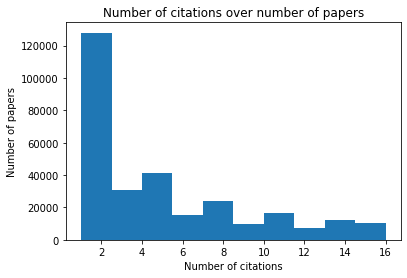

In [49]:
plt.title('Number of citations over number of papers')
plt.ylabel('Number of papers')
plt.xlabel('Number of citations')
plt.hist(p_cite_count.values(), range=(1, 16));

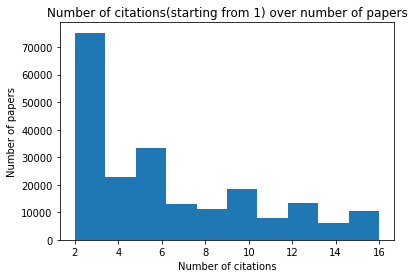

In [50]:
plt.title('Number of citations(starting from 1) over number of papers')
plt.ylabel('Number of papers')
plt.xlabel('Number of citations')
plt.hist(p_cite_count.values(), range=(2, 16));

Let us see what topic is dominant among our publications

In [51]:
# recent publications
recent_group_sizes = corpus[corpus.recency < 5].groupby('fieldsOfStudy').size()

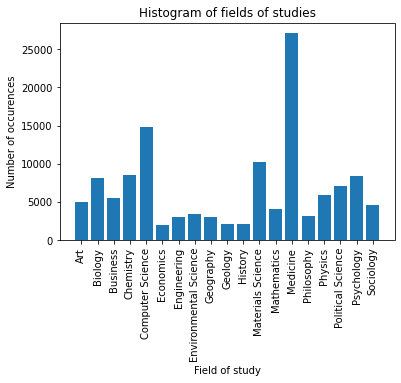

In [52]:
plt.bar(range(len(recent_group_sizes.index)), recent_group_sizes)
plt.title('Histogram of fields of studies')
plt.ylabel('Number of occurences')
plt.xlabel('Field of study')
plt.xticks(range(len(recent_group_sizes.index)), recent_group_sizes.index, rotation=90);

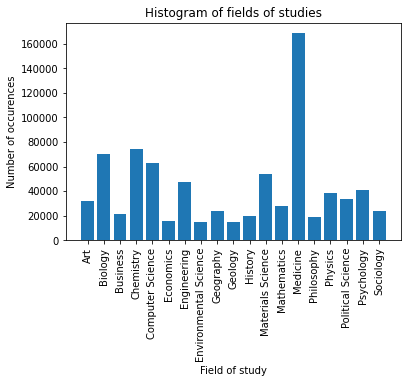

In [53]:
group_sizes = corpus.groupby('fieldsOfStudy').size()
plt.bar(range(len(group_sizes.index)), group_sizes)
plt.title('Histogram of fields of studies')
plt.ylabel('Number of occurences')
plt.xlabel('Field of study')
plt.xticks(range(len(group_sizes.index)), group_sizes.index, rotation=90);

In [54]:
import seaborn as sns

Heatmap will help us understand which features have strong correlations

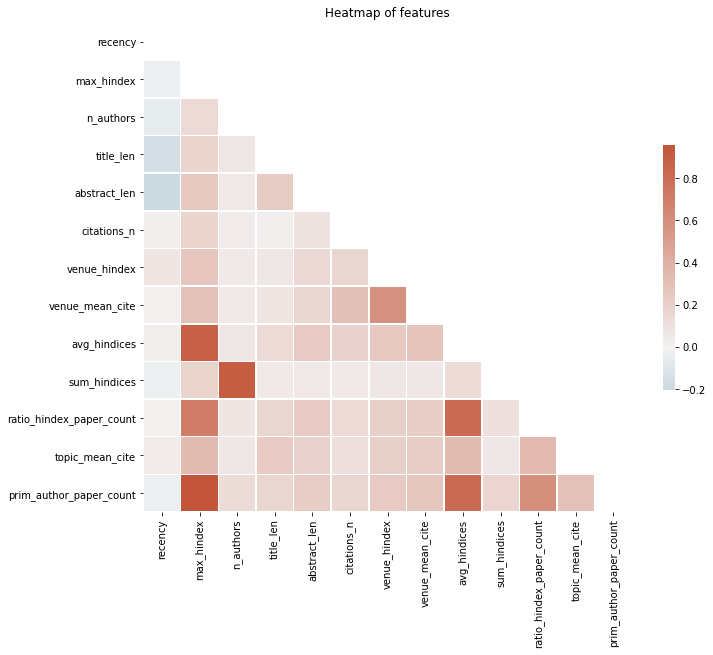

In [55]:
corr = corpus.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.title('Heatmap of features')
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Let us see how many papers were published each year

Text(0, 0.5, 'number of papers')

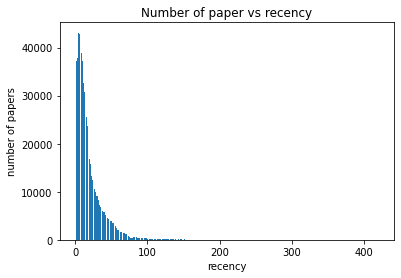

In [58]:
series = corpus.groupby('recency').size()

plt.bar(series.index, series)
plt.title('Number of paper vs recency')
plt.xlabel('recency')
plt.ylabel('number of papers')

### Most common journal name

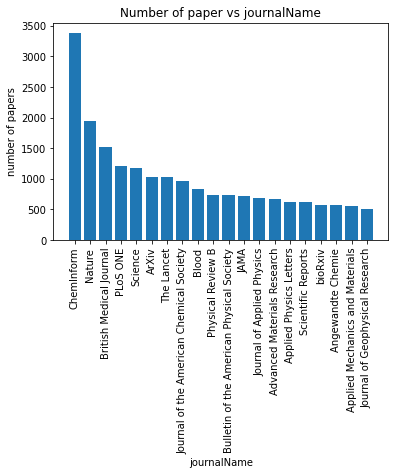

In [69]:
series = corpus.groupby('journalName').size()
series = series.sort_values(ascending=False).iloc[:20]

plt.bar(series.index, series)
plt.title('Number of paper vs journalName')
plt.xlabel('journalName')
plt.ylabel('number of papers')
plt.xticks(rotation=90);

## Store results

We do not want to lose all our analysis results.

Thus we will store the dataframe

In [70]:
# observe columns remaining and memory usage
corpus.info()

<class 'pandas.core.frame.DataFrame'>
Index: 950001 entries, 33b237709dbd53953a750355115b57ccb6690da1 to e3d5bbcd80b5b5927799164a8538d62966492fe5
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   recency                   950001 non-null  float64
 1   venue                     216833 non-null  object 
 2   journalName               462745 non-null  object 
 3   fieldsOfStudy             803021 non-null  object 
 4   max_hindex                950001 non-null  int64  
 5   n_authors                 950001 non-null  int64  
 6   title_len                 950001 non-null  int64  
 7   abstract_len              950001 non-null  int64  
 8   citations_n               950001 non-null  int64  
 9   venue_hindex              950001 non-null  int64  
 10  venue_mean_cite           950001 non-null  float64
 11  avg_hindices              950001 non-null  float64
 12  sum_hindices              950001

In [71]:
# generate a csv file from the dataframe
corpus.to_csv('corpus.csv')

In [72]:
# store all environment packages
!pip freeze > requirements.txt

Now, let's move data to the google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [74]:
ls drive/MyDrive/project_sber

author_citation_info.pickle  corpus.csv   dataretr.py  info.py
citation_info.pickle         dataprep.py  features.py  requirements.txt


In [75]:
cp requirements.txt corpus.csv dataprep.py dataretr.py info.py drive/MyDrive/project_sber/

In [76]:
ls drive/MyDrive/project_sber

author_citation_info.pickle  corpus.csv   dataretr.py  info.py
citation_info.pickle         dataprep.py  features.py  requirements.txt
